In [1]:
!pip install ucimlrepo

In [2]:
!pip install feature-fabrica --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.9 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=1fbce7a967978beb3722448b090a2d13d64afc2242e0db97d4180b0998e69e76
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully unin

# Import Packages

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

# Load Data

In [2]:
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Sep 09 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [3]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [4]:
adult.metadata.keys()

dict_keys(['uci_id', 'name', 'repository_url', 'data_url', 'abstract', 'area', 'tasks', 'characteristics', 'num_instances', 'num_features', 'feature_types', 'demographics', 'target_col', 'index_col', 'has_missing_values', 'missing_values_symbol', 'year_of_dataset_creation', 'last_updated', 'dataset_doi', 'creators', 'intro_paper', 'additional_info'])

In [5]:
adult.metadata.abstract

'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. '

In [6]:
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


# Data Cleaning

In [7]:
X.replace('?', pd.NA, inplace=True)

<ipython-input-7-12a3b5e88b54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace('?', pd.NA, inplace=True)


In [8]:
X.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
education-num,int64
marital-status,object
occupation,object
relationship,object
race,object
sex,object


In [9]:
columns_with_missing =  ['workclass', 'occupation', 'native-country']
for col in columns_with_missing:
  print(f"Percentage of values missing for column {col}: {X[col].isna().sum()/len(X)}")

Percentage of values missing for column workclass: 0.05730723557593874
Percentage of values missing for column occupation: 0.05751197739650301
Percentage of values missing for column native-country: 0.017546374022357807


In [10]:
missing_one_hot_df = X.isna().astype(int)[columns_with_missing]
missing_one_hot_df.columns = [c + '_missing' for c in columns_with_missing]
X = pd.concat([X, missing_one_hot_df], axis=1)

In [11]:
# Fill missing values with mode (for categorical variables)
for col in columns_with_missing:
  X[col].fillna(X[col].mode()[0], inplace=True)

In [12]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass_missing,occupation_missing,native-country_missing
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,0,0


In [13]:
df = pd.concat([X, y], axis=1)

In [14]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass_missing,occupation_missing,native-country_missing,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,0,0,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0,0,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,0,0,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,0,0,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,0,0,<=50K


In [15]:
# we need to get rid of "." in labels
y.value_counts()

,count
income,
<=50K,24720
<=50K.,12435
>50K,7841
>50K.,3846


# Visualizations

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>,
        <Axes: title={'center': 'education-num'}>],
       [<Axes: title={'center': 'capital-gain'}>,
        <Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>],
       [<Axes: title={'center': 'workclass_missing'}>,
        <Axes: title={'center': 'occupation_missing'}>,
        <Axes: title={'center': 'native-country_missing'}>]], dtype=object)

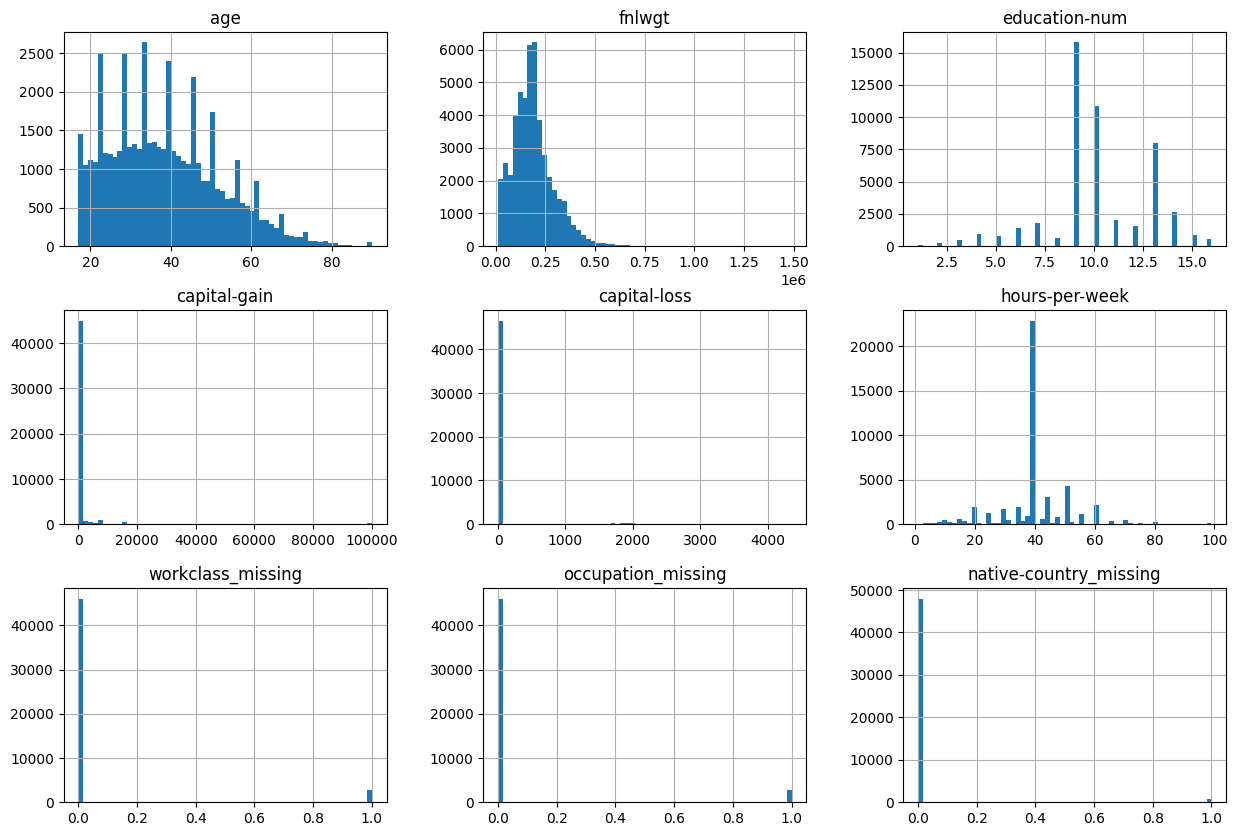

In [16]:
# data is imbalanced
X.hist(figsize = (15, 10), bins= 60)

In [17]:
def pieplot(df, column):
    label = df[column].unique().tolist()
    data = df[column].value_counts()
    plt.figure(figsize = (5, 5))
    plt.pie(data, labels = label, autopct = "%.0f%%")
    plt.title(column)
    plt.show()

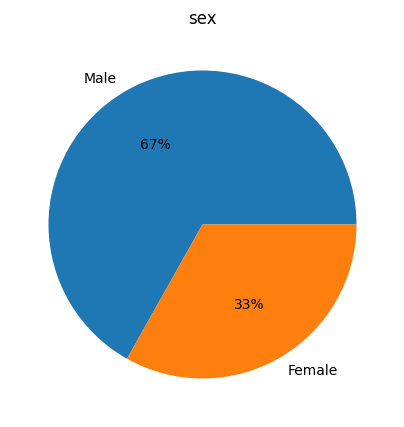

In [18]:
pieplot(X, "sex")

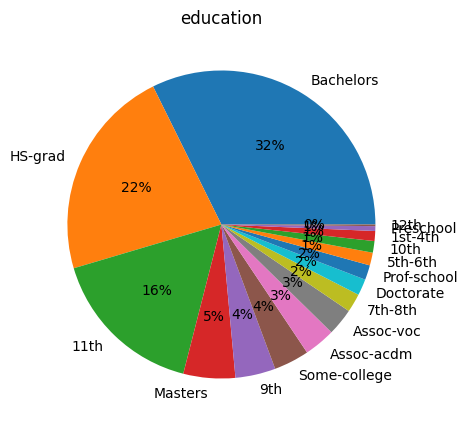

In [19]:
pieplot(X, "education")

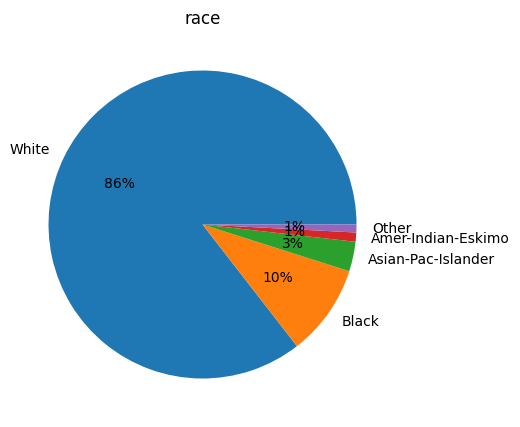

In [20]:
pieplot(X, "race")

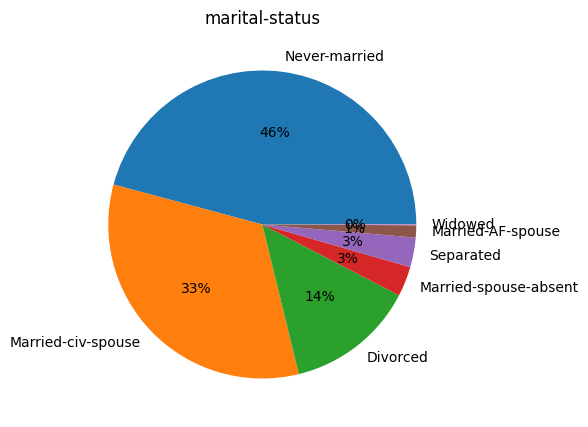

In [21]:
pieplot(X, "marital-status")

# Baseline Model

In [22]:
BASIC_FEATURE_DEFINITION = f"""
# examples/basic_features.yaml
age:
  description: "age"
  data_type: "int32"

workclass:
  description: "Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked."
  data_type: "int32"
  transformation:
    one_hot:
      _target_: feature_fabrica.transform.LabelEncode

fnlwgt:
  description: "Final weight, which represents the number of people the observation is meant to represent."
  data_type: "int32"

education:
  description: "Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool."
  data_type: "int32"
  transformation:
    one_hot:
      _target_: feature_fabrica.transform.OneHotEncode

education-num:
  description: "Numeric representation of education level."
  data_type: "int32"

marital-status:
  description: "Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse."
  data_type: "int32"
  transformation:
    one_hot:
      _target_: feature_fabrica.transform.OneHotEncode

occupation:
  description: "Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces."
  data_type: "int32"
  transformation:
    one_hot:
      _target_: feature_fabrica.transform.OneHotEncode

relationship:
  description: "Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried."
  data_type: "int32"
  transformation:
    one_hot:
      _target_: feature_fabrica.transform.OneHotEncode

race:
  description: "White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black."
  data_type: "int32"
  transformation:
    one_hot:
      _target_: feature_fabrica.transform.OneHotEncode

sex:
  description: "Female, Male."
  data_type: "int32"
  transformation:
    label_encode:
      _target_: feature_fabrica.transform.LabelEncode

capital-gain:
  description: "Capital gains in dollars."
  data_type: "int32"

capital-loss:
  description: "Capital losses in dollars."
  data_type: "int32"

hours-per-week:
  description: "Hours worked per week."
  data_type: "int32"

native-country:
  description: "United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, etc."
  data_type: "int32"
  transformation:
    one_hot:
      _target_: feature_fabrica.transform.OneHotEncode

income:
  description: "Income classification: >50K or <=50K."
  data_type: "int32"
  transformation:
    strip:
      _target_: feature_fabrica.transform.Strip
      chars: '.'
    label:
      _target_: feature_fabrica.transform.LabelEncode
      categories: ["<=50K", ">50K"]
"""


In [23]:
import yaml

# Convert the string to a Python dictionary
feature_definition_dict = yaml.safe_load(BASIC_FEATURE_DEFINITION)

# Specify the path where you want to save the YAML file
yaml_file_path = 'basic_features.yaml'

# Save the dictionary to a YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(feature_definition_dict, file, default_flow_style=False, sort_keys=False)

print(f"YAML file saved as {yaml_file_path}")


YAML file saved as basic_features.yaml


In [24]:
df_dict = {
    col: df[col].to_numpy(dtype=np.str_) if df[col].dtype == 'object' else df[col].to_numpy(dtype=np.int32)
    for col in df.columns
}

In [25]:
import numpy as np
from feature_fabrica.core import FeatureManager

feature_manager = FeatureManager(
    config_path="./", config_name="basic_features"
)
results = feature_manager.compute_features(df_dict)

2024-09-11 11:56:24 | INFO     | feature_fabrica.yaml_parser:load_yaml:16 - Reading Feature Definition YAML from .//basic_features.yaml
2024-09-11 11:56:24 | INFO     | feature_fabrica.core:_build_features:198 - Building features from feature definition YAML
2024-09-11 11:56:24 | INFO     | feature_fabrica.core:compile:225 - Compiling features and feature dependencies...


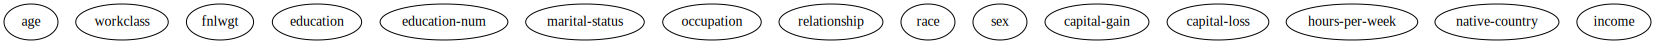

In [26]:
feature_manager.get_visual_dependency_graph()

In [27]:
# Convert 2D arrays to a flat structure for DataFrame creation
flattened_dict = {}
for col, values in results.items():
    if values.ndim == 2:
        # Flatten 2D arrays and add column names for each feature
        for i in range(values.shape[1]):
            flattened_dict[f"{col}_{sorted(list(X[col].unique()))[i]}"] = values[:, i]
    else:
        # Keep 1D arrays as is
        flattened_dict[col] = values

# Create DataFrame from flattened dictionary
df_processed = pd.DataFrame(flattened_dict)

In [28]:
df_processed.head()

,fnlwgt,age,education-num,workclass,sex,capital-gain,capital-loss,hours-per-week,relationship_Husband,relationship_Not-in-family,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,77516,39,13,6,1,2174,0,40,0,1,...,0,0,0,0,0,0,0,1,0,0
1,83311,50,13,5,1,0,0,13,1,0,...,0,0,0,0,0,0,0,1,0,0
2,215646,38,9,3,1,0,0,40,0,1,...,0,0,0,0,0,0,0,1,0,0
3,234721,53,7,3,1,0,0,40,1,0,...,0,0,0,0,0,0,0,1,0,0
4,338409,28,13,3,0,0,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
y = df_processed['income']
X = df_processed.drop(columns='income')
# Ensure that X and y have the same number of samples
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Features shape: (48842, 97)
Target shape: (48842,)


In [30]:
# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7431
           1       0.73      0.62      0.67      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769



In [31]:
confusion_matrix(y_test, y_pred)

array([[6886,  545],
       [ 890, 1448]])

In [32]:
# Get feature importances
importances = rf.feature_importances_
features = X.columns
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Print feature importances
print(feature_importances)

                                      feature  importance
0                                      fnlwgt    0.175270
1                                         age    0.154191
5                                capital-gain    0.092431
7                              hours-per-week    0.086667
2                               education-num    0.066672
..                                        ...         ...
92                    native-country_Thailand    0.000060
34                        education_Preschool    0.000054
71                    native-country_Honduras    0.000028
83  native-country_Outlying-US(Guam-USVI-etc)    0.000028
70          native-country_Holand-Netherlands    0.000005

[97 rows x 2 columns]


                              feature  importance
0                              fnlwgt    0.175270
1                                 age    0.154191
5                        capital-gain    0.092431
7                      hours-per-week    0.086667
2                       education-num    0.066672
16  marital-status_Married-civ-spouse    0.062660
8                relationship_Husband    0.041509
3                           workclass    0.037772
6                        capital-loss    0.031586
18       marital-status_Never-married    0.028247


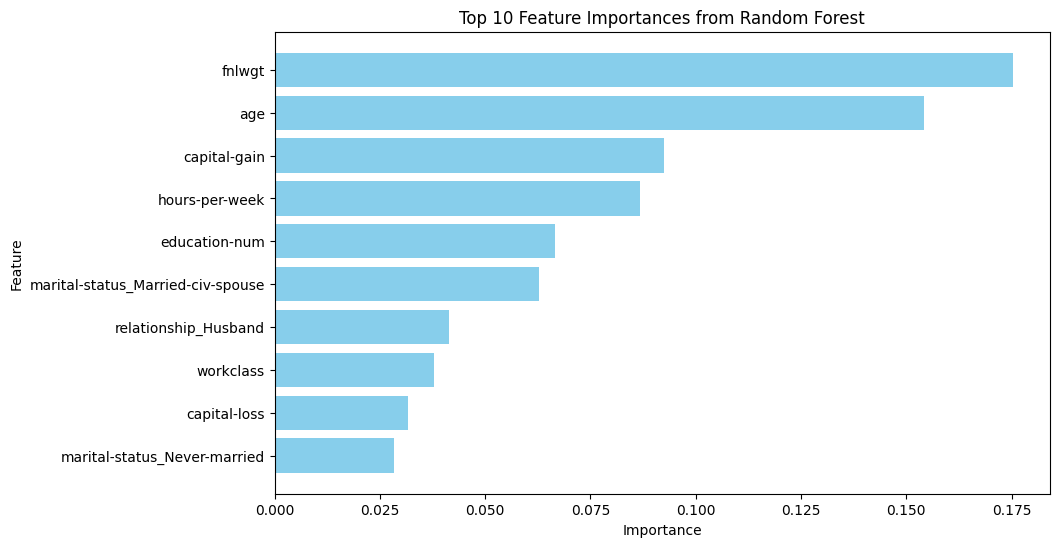

In [33]:
# Select top 10 important features
top_10_features = feature_importances.head(10)

# Print top 10 feature importances
print(top_10_features)

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Let's cook some more features

In [83]:
EXTENDED_FEATURE_DEFINITION = f"""
work_intensity:
  description: "This gives a rough estimate of the ratio of time worked per week relative to age. Younger individuals working more hours may indicate higher work intensity."
  data_type: "float32"
  dependencies: [age, hours-per-week]
  transformation:
    divide:
      _target_: feature_fabrica.transform.DivideTransform
      numerator: hours-per-week
      denominator: age

cap_gain_hours_week:
  description: "Highlights individuals with substantial capital gains who may work fewer hours but still achieve high income."
  data_type: "float32"
  dependencies: [capital-gain, hours-per-week]
  transformation:
    divide:
      _target_: feature_fabrica.transform.DivideTransform
      numerator: capital-gain
      denominator: hours-per-week

education_investment:
  description: "Helps identify individuals who have invested a higher proportion of their life in education, which might impact income levels."
  data_type: "float32"
  dependencies: [education-num, age]
  transformation:
    divide:
      _target_: feature_fabrica.transform.DivideTransform
      numerator: education-num
      denominator: age

cap_gain_adjusted:
  description: "This adjusted value provides a clearer picture of the actual financial gains from capital."
  data_type: "int32"
  dependencies: [capital-gain, capital-loss]
  transformation:
    subtract:
      _target_: feature_fabrica.transform.SubtractReduce
      iterable: [capital-gain, capital-loss]

financial_gain_to_work_experience:
  description: "This gives ratio of the actual financial gains to the assumed years of work experience"
  data_type: "float32"
  dependencies: [age, education-num, cap_gain_adjusted]
  transformation:
    subtract:
      _target_: feature_fabrica.transform.SubtractReduce
      iterable: [age, education-num]
    divide:
      _target_: feature_fabrica.transform.DivideTransform
      numerator: cap_gain_adjusted

total_cap_gain_workclass:
  description: "Mean capital gain per workclass."
  data_type: "float32"
  dependencies: [cap_gain_adjusted, workclass]
  transformation:
    import:
      _target_: feature_fabrica.transform.FeatureImporter
      feature: cap_gain_adjusted
      transform_stage: subtract
    group:
      _target_: feature_fabrica.transform.GroupByReduce
      key_feature: workclass
      reduce_func: mean
      axis: -1

avg_education_investment_age:
  description: "Mean education ivestment per age."
  data_type: "float32"
  dependencies: [education_investment, age]
  transformation:
    import:
      _target_: feature_fabrica.transform.FeatureImporter
      feature: education_investment
      transform_stage: divide
    group:
      _target_: feature_fabrica.transform.GroupByReduce
      key_feature: age
      reduce_func: mean
      axis: -1

education_investment_to_avg:
  description: "Ratio between person's education investment to the average of their age."
  data_type: "float32"
  dependencies: [education_investment, avg_education_investment_age]
  transformation:
    divide:
      _target_: feature_fabrica.transform.DivideTransform
      numerator: education_investment
      denominator: avg_education_investment_age
"""

In [84]:
# let's reload our basic features
basic_feature_definition_dict = yaml.safe_load(BASIC_FEATURE_DEFINITION)
# load new features
extended_feature_definition_dict = yaml.safe_load(EXTENDED_FEATURE_DEFINITION)
# add them together
feature_definition_dict = basic_feature_definition_dict | extended_feature_definition_dict

# Specify the path where you want to save the YAML file
yaml_file_path = 'extended_features.yaml'

# Save the dictionary to a YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(feature_definition_dict, file, default_flow_style=False, sort_keys=False)

print(f"YAML file saved as {yaml_file_path}")


YAML file saved as extended_features.yaml


In [85]:
feature_manager = FeatureManager(
    config_path="./", config_name="extended_features"
)
results = feature_manager.compute_features(df_dict)

2024-09-11 12:08:04 | INFO     | feature_fabrica.yaml_parser:load_yaml:16 - Reading Feature Definition YAML from .//extended_features.yaml
2024-09-11 12:08:04 | INFO     | feature_fabrica.core:_build_features:198 - Building features from feature definition YAML
2024-09-11 12:08:04 | INFO     | feature_fabrica.core:compile:225 - Compiling features and feature dependencies...


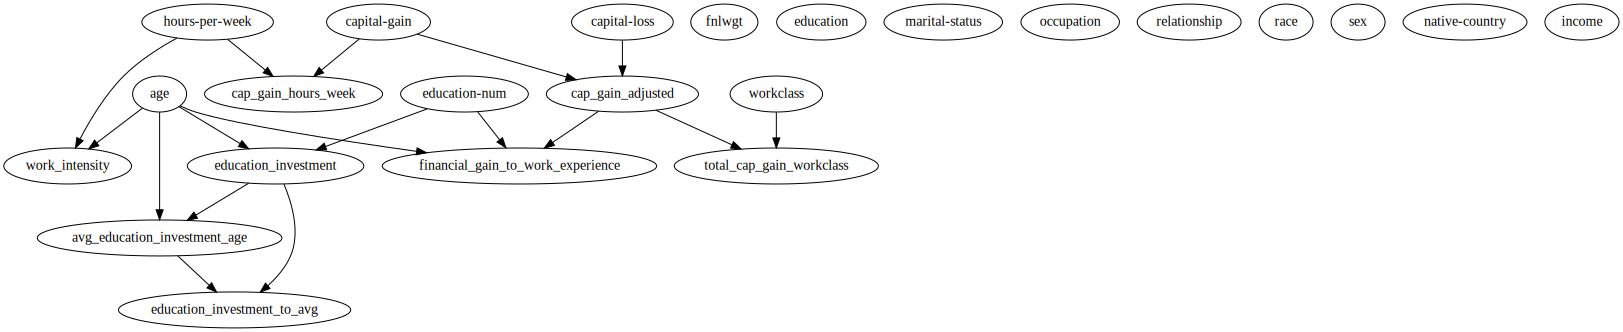

In [86]:
feature_manager.get_visual_dependency_graph()

In [87]:
# Convert 2D arrays to a flat structure for DataFrame creation
flattened_dict = {}
for col, values in results.items():
    if values.ndim == 2:
        # Flatten 2D arrays and add column names for each feature
        for i in range(values.shape[1]):
            flattened_dict[f"{col}_{sorted(list(df[col].unique()))[i]}"] = values[:, i]
    else:
        # Keep 1D arrays as is
        flattened_dict[col] = values

# Create DataFrame from flattened dictionary
df_processed_extended = pd.DataFrame(flattened_dict)

In [88]:
# vibe check
df_processed_extended[['capital-gain', 'capital-loss','total_cap_gain_workclass', 'avg_education_investment_age', 'education_investment', 'education_investment_to_avg', 'income']].head(20)

,capital-gain,capital-loss,total_cap_gain_workclass,avg_education_investment_age,education_investment,education_investment_to_avg,income
0,2174,0,673.635538,0.270464,0.333333,1.232450,0
1,0,0,1672.397204,0.208499,0.260000,1.247009,0
2,0,0,786.385125,0.275587,0.236842,0.859409,0
3,0,0,786.385125,0.189502,0.132075,0.696961,0
4,0,0,786.385125,0.364202,0.464286,1.274803,0
5,0,0,786.385125,0.277323,0.378378,1.364398,0
6,0,0,786.385125,0.208780,0.102041,0.488748,0
7,0,0,1672.397204,0.191083,0.173077,0.905768,1
8,14084,0,786.385125,0.326865,0.451613,1.381648,1
9,5178,0,786.385125,0.254118,0.309524,1.218031,1


In [89]:
y = df_processed_extended['income']
X = df_processed_extended.drop(columns='income')
# Ensure that X and y have the same number of samples
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Features shape: (48842, 105)
Target shape: (48842,)


In [90]:
# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

# We improved accuracy by 1%

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7431
           1       0.73      0.62      0.67      2338

    accuracy                           0.86      9769
   macro avg       0.81      0.78      0.79      9769
weighted avg       0.85      0.86      0.85      9769



In [92]:
confusion_matrix(y_test, y_pred)

array([[6902,  529],
       [ 885, 1453]])

In [93]:
# Get feature importances
importances = rf.feature_importances_
features = X.columns
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Print feature importances
print(feature_importances)

                                       feature  importance
0                                       fnlwgt    0.115883
104                education_investment_to_avg    0.070239
98                              work_intensity    0.061369
100                          cap_gain_adjusted    0.057053
1                                          age    0.051946
..                                         ...         ...
89                     native-country_Scotland    0.000046
26                         education_Preschool    0.000026
83   native-country_Outlying-US(Guam-USVI-etc)    0.000017
71                     native-country_Honduras    0.000014
70           native-country_Holand-Netherlands    0.000000

[105 rows x 2 columns]


                               feature  importance
0                               fnlwgt    0.115883
104        education_investment_to_avg    0.070239
98                      work_intensity    0.061369
100                  cap_gain_adjusted    0.057053
1                                  age    0.051946
37   marital-status_Married-civ-spouse    0.051227
29                relationship_Husband    0.051214
7                       hours-per-week    0.049667
99                education_investment    0.048333
102       avg_education_investment_age    0.046769


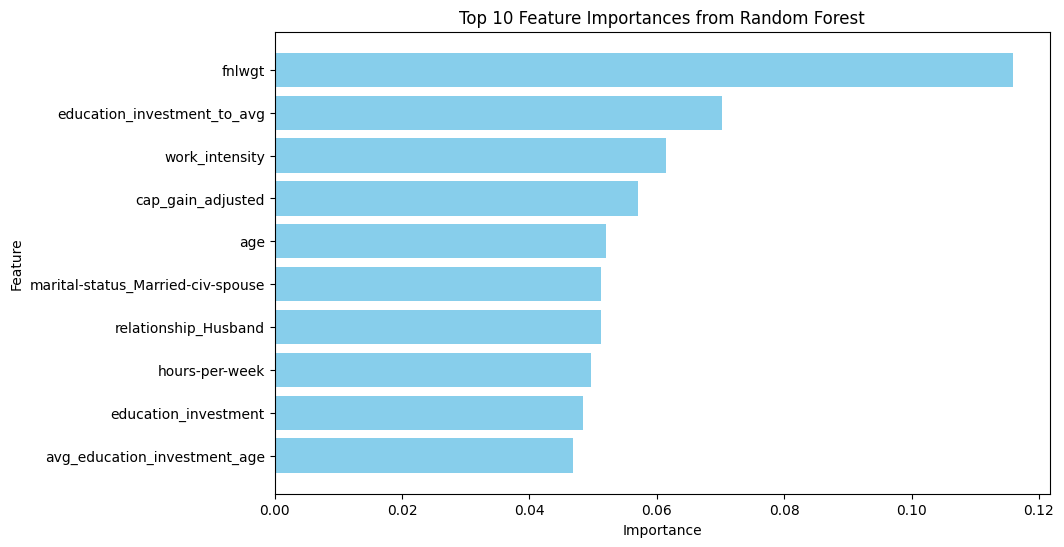

In [94]:
# Select top 10 important features
top_10_features = feature_importances.head(10)

# Print top 10 feature importances
print(top_10_features)

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()